# Fantasy Football AI project

Team Selections - Gameweek 1 Clean

This notebook is a cleaned code version of the team_selections_gw1 notebook. We aim to condense the code in that notebook into a few simplified functions with the same output. The narrative is simplified here. This is a stepping stone notebook pre-deployment

The team_selections_gw1 notebook should be consulted for any background, narrative, and notes

We'll briefly re-iterate the problem here for clarity:

**Problem 1**: What is the highest scoring team, budget permitting, that could have been set and left on gw1? i.e. given the current points totals for all players, which team, when selected in gw 1 would give you the highest possible return at the current date?

**Note** We use gameweek 2 as the starting point but this is only because gw1 and 2 were essentially a split gameweek so not all players we're interested in have stats for gameweek one!! The spirit of this task remains as a gameweek 1 team selection.

In [1]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
pd.set_option('display.max_columns', None)

In [35]:
# Read in the base dataset and filter for relevant features
players = pd.read_csv("players.csv")[["element", "round", "total_points" ]]
plr_info = pd.read_csv("basic_player_info.csv")[["element_type", "id", "web_name", "short_name"]]
cumulative = pd.read_csv("cumulative_points.csv")[["element", "round", "cum_points", "cost"]]

In [36]:
cumulative

,element,round,cum_points,cost
0,1,1,0,70
1,1,2,0,69
2,1,3,0,69
3,1,4,0,68
4,1,5,0,68
...,...,...,...,...
17792,682,28,0,40
17793,683,27,0,45
17794,683,28,0,45
17795,684,27,0,45


### Functions

In [20]:
#Create a function that takes the data and merges into a useful set

def merge_data(players, plr_info, cumulative):
    """
    In this function we'll take the available datasets, filter for useful features and values and merge into one 
    master set
    """

    # join the players and info sets
    data = players.merge(plr_info, how="left", left_on="element", right_on="id").drop("element", axis=1)
    
    # join the data and cumulative points sets
    data = data.merge(cumulative, how="left", left_on=["id", "round"], 
                      right_on=["element", "round"]).drop("element", axis=1)


    data = data[["id", "web_name", "round", "total_points", "element_type", "short_name", "cum_points"]]
    
    return data

In [21]:
data = merge_data(players, plr_info, cumulative)

In [24]:
data.head()

,id,web_name,round,total_points,element_type,short_name,cum_points
0,1,Özil,1,0,3,ARS,0.0
1,1,Özil,2,0,3,ARS,0.0
2,1,Özil,3,0,3,ARS,0.0
3,1,Özil,4,0,3,ARS,0.0
4,1,Özil,5,0,3,ARS,0.0


In [41]:
# Create a function that prepares our data for use with the team construction task
def build_prepset():
    """
    In this function we'll achieve the following
    1. Call in the merged data, 
    2. Remove players who weren't available at gameweek 2, 
    3. Remove players who have zero points at the latest gameweek 
    4. Add in the players cost at gw2.
    5. Create a value feature
    """
    # Call the merge data function
    data = merge_data(players, plr_info, cumulative)
    
    # First we'll check which players were available in gw2 and filter our data for these players only
    gw2_true = data[data["round"]==2]
    # Create a list of ids for these players
    gw2_id_list = gw2_true.id.tolist()
    # Now select all the available players in all rounds from our data
    available_players = data.loc[data["id"].isin(gw2_id_list)]
    
    # Now we'll remove all players who have 0 points at the latest gw, first filter for latest gw
    latest_round = available_players[available_players["round"]==28]
    # Now filter in latest round for players scoring 1 or more points
    scorers = latest_round[latest_round.cum_points>0]
    
    # Get the gw 2 costs from the cumulative df cost feature
    week_two_cost = cumulative[cumulative["round"]==2][["element", "cost"]]
    
    data = scorers.merge(week_two_cost, how="left", left_on="id", right_on="element").drop("element", axis=1)
    
    # Finally we create a value feature (points per £million) which will assist our team selection
    dec = 1
    data["value"] = data.cum_points / data.cost
    data["value"] = data["value"].apply(lambda x: round(x, dec)) # Round the values down to 1 decimal place
    
    
    return data

In [47]:
df = build_prepset()

In [48]:
# Review our prepared data
df.head(6)

,id,web_name,round,total_points,element_type,short_name,cum_points,cost,value
0,3,David Luiz,28,2,2,ARS,39.0,55,0.7
1,4,Aubameyang,28,0,3,ARS,104.0,120,0.9
2,5,Cédric,28,2,2,ARS,28.0,49,0.6
3,6,Lacazette,28,8,4,ARS,98.0,85,1.2
4,7,Mustafi,28,0,2,ARS,3.0,50,0.1
5,8,Leno,28,2,1,ARS,101.0,50,2.0


In [57]:
# Create a function that builds our baseline team - i.e. a team consisting of highest points scorers
def baseline_team():
    """
    In this function we'll build a baseline GW1 team that selects the highest scoring players regardless of costs
    """
    # Call the prepset to create the full set of available players
    df = build_prepset()
    
    # Create position sets sorted in descending order of points scored
    gk = df[df.element_type==1].sort_values(by="cum_points", ascending=False)
    dfn = df[df.element_type==2].sort_values(by="cum_points", ascending=False)
    mid = df[df.element_type==3].sort_values(by="cum_points", ascending=False)
    fwd = df[df.element_type==4].sort_values(by="cum_points", ascending=False)
    
    # Select the players for our squad based on the number of allowed players per position in the FPL game
    gk_selected = gk.iloc[0:2]
    def_selected = dfn.iloc[0:5]
    mid_selected = mid.iloc[0:5]
    fwd_selected = fwd.iloc[0:3]

    # Store the squad player's ids in a dataframe. We use ids over names as some names are duplicated
    gk_ids = gk_selected.id.values.tolist()
    def_ids = def_selected.id.values.tolist()
    mid_ids = mid_selected.id.values.tolist()
    fwd_ids = fwd_selected.id.values.tolist()

    
    # Let's store the team in a data frame
    team_list = [gk_ids, def_ids, mid_ids, fwd_ids]
    team_frame = pd.DataFrame(team_list).T
    team_frame.rename(columns = {0: "gk", 1:"def", 2:"mid", 3:"fwd"}, inplace=True)

    # Now, select the team_frame data points from our prepared df to create a the base team
    base_team = df[df.id.isin(team_frame.values.reshape((20)).tolist())].sort_values(by="element_type", 
                                                                                     ascending=True)
    
    
    # Finally we sort the players by element and then in descending order of points scored
    base_gk = base_team[base_team.element_type==1].sort_values(by="cum_points", ascending=False)
    base_dfn = base_team[base_team.element_type==2].sort_values(by="cum_points", ascending=False)
    base_mid = base_team[base_team.element_type==3].sort_values(by="cum_points", ascending=False)
    base_fwd = base_team[base_team.element_type==4].sort_values(by="cum_points", ascending=False)

    base_team = pd.DataFrame(columns=base_gk.columns)
    base_team = base_team.append(base_gk).append(base_dfn).append(base_mid).append(base_fwd)
    base_team.reset_index(inplace=True)
    base_team.drop("index", axis=1, inplace=True)
    
    return base_team
    

In [58]:
baseline_team() # Boomed it

,id,web_name,round,total_points,element_type,short_name,cum_points,cost,value
0,12,Martínez,28,3,1,AVL,152.0,45,3.4
1,278,Ederson,28,6,1,MCI,129.0,60,2.1
2,435,Cresswell,28,2,2,WHU,135.0,50,2.7
3,273,Stones,28,14,2,MCI,122.0,50,2.4
4,277,Cancelo,28,12,2,MCI,122.0,55,2.2
5,200,Dallas,28,6,2,LEE,120.0,45,2.7
6,313,Wan-Bissaka,28,5,2,MUN,120.0,55,2.2
7,302,Fernandes,28,3,3,MUN,209.0,105,2.0
8,390,Son,28,1,3,TOT,179.0,89,2.0
9,254,Salah,28,3,3,LIV,174.0,120,1.4


In [59]:
# 1 decide on the index of players up for transfer out
def transfer_out(df):
    """
    df = base_team_sorted
    In this function we need to decide at what index, from the base squad, the player to be transfered is located at. 
    Typically, the indexes are set at the lowest scoring player location, however, could change!
    """

    # Set the baseline indexes to the location of poorest scoring player in the squad
    gk, dfn, mid, fwd = 1, 6, 11, 14
    
    # Check which players in our team are considered "low value" based on rules set out
    low_value = df[(df.cum_points<163) & (df.value<1.9)]
    low_value = low_value.sort_values(by="value", ascending=False)
    
    
    positions = df.groupby("element_type")
    
    for i in range(1, 5):
        pos = positions.get_group(i)
        new_transfer = pos[pos.web_name.isin(low_value.web_name)] 
        if i == 1 and new_transfer.shape[0]>0:
            gk = new_transfer.index.values[0]
        elif i == 2 and new_transfer.shape[0]>0:
            dfn = new_transfer.index.values[0]
        elif i == 3 and new_transfer.shape[0]>0:
            mid = new_transfer.index.values[0]
        elif i == 4 and new_transfer.shape[0]>0:
            fwd = new_transfer.index.values[0]
    
    
    return gk, dfn, mid, fwd

In [60]:
def scout(df, i):
    """
    In this function we generate a dataset of players which include the next player in each position who is to be 
    considered for transfer into the squad
    df = df(full list of available players)
    i is the iterable value from the master function
    """
    
    # Split the full list of available players into position sets
    gk = df[df.element_type==1].sort_values(by="cum_points", ascending=False)
    dfn = df[df.element_type==2].sort_values(by="cum_points", ascending=False)
    mid = df[df.element_type==3].sort_values(by="cum_points", ascending=False)
    fwd = df[df.element_type==4].sort_values(by="cum_points", ascending=False)
    
    
    
    # Set up an empty dataframe to store the next players in each position
    targets = pd.DataFrame(columns = gk.columns)

    # Store each of the next players in an isolated frame
    next_gk = gk.iloc[i+2].to_frame().T
    next_def = dfn.iloc[i+5].to_frame().T
    next_mid = mid.iloc[i+5].to_frame().T
    next_fwd = fwd.iloc[i+4].to_frame().T

    # Add the players into the empty dataframe
    targets = targets.append(next_gk).append(next_def).append(next_mid).append(next_fwd)
    
    
    # Return the scouted players frame
    return targets

In [61]:
def net_loss(df, targets, g_idx, d_idx, m_idx, f_idx):
    """
    In this function we calculate the potential loss of points of each player to be considered for transfer into 
    the squad and save them to a list. We then organise loss values in ascending order and create a list of 
    indexes that the ordered values are found in the initial loss list
    df = base_team_sorted
    """
    
    gk, dfn, mid, fwd = g_idx, d_idx, m_idx, f_idx
    
    # Set an empty list to store our player losses
    net_loss = []
    
    
    # calculate the potential loss each transfer would incur
    gk_loss = df.cum_points.iloc[gk] - targets.cum_points.iloc[0]
    def_loss = df.cum_points.iloc[dfn] - targets.cum_points.iloc[1]
    mid_loss = df.cum_points.iloc[mid] - targets.cum_points.iloc[2]
    fwd_loss = df.cum_points.iloc[fwd] - targets.cum_points.iloc[3]

    # Add each loss to the net_loss list which is our unordered list of net losses
    net_loss.extend([gk_loss, def_loss, mid_loss, fwd_loss])

    # Create an ordered list of net losses high to low
    ordered_loss = net_loss.copy()
    ordered_loss.sort()

    # Now create an ordered list of indexes - i.e the index in net_loss that we can find values in the ordered_loss
    # Note the values have 1 added to equate to the element types 1=gk, 2=def, 3=mid, 4=fwd
    ordered_idx = [net_loss.index(ordered_loss[x])+1 for x in range(len(ordered_loss))]
    
    return ordered_idx

In [66]:
def generate_squad():
    """
    In this function we call to all our supporting functions, make the final decision on whether a player should
    be transfered, generate and return the best possible performing squad
    
    """
    best_team = baseline_team()
    g_idx, d_idx, m_idx, f_idx = transfer_out(best_team)
    
    for i in range(29): 
        
        players = scout(df, i) # Note df is the full list of available players
        
        ordered_idx = net_loss(best_team, players, g_idx, d_idx, m_idx, f_idx)
    
        for m, n in enumerate(ordered_idx):
            if n == 1 and players.iloc[0].cost < best_team.iloc[g_idx].cost: #index 1 in base team == worst keeper
                best_team = best_team.drop(index=g_idx, axis=0)
                best_team.loc[g_idx] = players.iloc[0]
                best_team.sort_index(inplace=True)

            elif n == 2 and players.iloc[1].cost < best_team.iloc[d_idx].cost: # index 6 in base team == worst defender
                best_team= best_team.drop(index=d_idx, axis=0)
                best_team.loc[d_idx] = players.iloc[1]
                best_team.sort_index(inplace=True)

            elif n == 3 and players.iloc[2].cost < best_team.iloc[m_idx].cost: # index 11 in base team == worst midfield
                best_team = best_team.drop(index=m_idx, axis=0)
                best_team.loc[m_idx] = players.iloc[2]
                best_team.sort_index(inplace=True)

            elif n == 4 and players.iloc[3].cost < best_team.iloc[f_idx].cost: # index 11 in base team == worst midfield
                best_team = best_team.drop(index=f_idx, axis=0)
                best_team.loc[f_idx] = players.iloc[3]
                best_team.sort_index(inplace=True)

            
        # If we have achieved a squad value equal or less than the £100M budget then we can break the loop    
        if best_team.cost.sum()/10 < 100:
            break
        else:
            continue
    
    
    return best_team

In [67]:
squad_baby = generate_squad()

In [68]:
squad_baby ###!!!!! YEEEHHHHH BAAABBY

,id,web_name,round,total_points,element_type,short_name,cum_points,cost,value
0,12,Martínez,28,3,1,AVL,152.0,45,3.4
1,213,Meslier,28,11,1,LEE,122.0,45,2.7
2,435,Cresswell,28,2,2,WHU,135.0,50,2.7
3,273,Stones,28,14,2,MCI,122.0,50,2.4
4,277,Cancelo,28,12,2,MCI,122.0,55,2.2
5,200,Dallas,28,6,2,LEE,120.0,45,2.7
6,42,Targett,28,4,2,AVL,116.0,45,2.6
7,302,Fernandes,28,3,3,MUN,209.0,105,2.0
8,390,Son,28,1,3,TOT,179.0,89,2.0
9,254,Salah,28,3,3,LIV,174.0,120,1.4


In [69]:
# Let's display a visualisation of our squad
x_coord = [5, 9, 1, 4, 7, 10, 13, 1, 4, 7, 10, 13, 4, 7, 10]
y_coord = [10, 10, 7, 7, 7, 7, 7, 4, 4, 4, 4, 4, 1, 1, 1,]
names =  squad_baby.web_name.values.tolist()

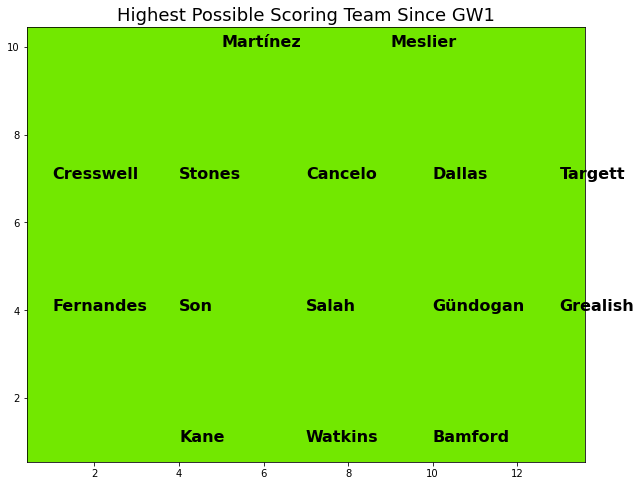

In [71]:
# Add a strip color into the team dataframe to color the plot 
plt.figure(figsize=(10, 8))

plt.scatter(x_coord, y_coord, marker="")
plt.rcParams['axes.facecolor'] = "#72e800" # Change plot background to green for grass colour :)
plt.title("Highest Possible Scoring Team Since GW1", fontsize=18)

for i, (j,k,m) in enumerate(zip(names, x_coord, y_coord)):
    plt.annotate(j, (k, m), fontsize=16, color="k", fontweight="bold")